### 목적
- 이전에 잘못된 값이 들어가던 avg_subscription_period 값을 고쳤을 때 모델 결과가 얼마나 변하는지 확인

### 살펴볼 것
1. 모델의 전반적인 성능 변화
2. 특정 고객(VOC) score
3. 6월 prediction score distribution

In [2]:
import lightgbm as lgb

import pandas as pd
import numpy as np
import pickle
import time
import shap
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

from sm_utils import sampling, evaluate, save_model, load_model
from sm_utils import make_train_data,  make_test_data, df_to_md_table

In [3]:
DATA_PATH = '/home/dmig/work/upsell/data'
MODEL_PATH = '/home/dmig/work/upsell/model'

***

## Load data

In [4]:
df_mart01 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201901.pkl'))
df_mart04 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201904.pkl'))
df_mart05 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201905.pkl'))

df_input06 = pd.read_pickle(os.path.join(DATA_PATH, 'df_input_201906.pkl'))

In [5]:
df_mart01.shape, df_mart04.shape, df_mart05.shape, df_input06.shape

((18176215, 81), (18626176, 81), (18707537, 81), (18855464, 80))

In [6]:
from functools import reduce

def merge_df(df_mart, ym):
    
    df_tmp = df_mart[['svc_mgmt_num', 'avg_subscription_period']]
    
    avg_sub = pd.read_pickle(os.path.join(DATA_PATH, 'avg_subscription_period_{}.pkl'.format(ym)))
    fee_chg_cnt = pd.read_pickle(os.path.join(DATA_PATH, 'fee_chg_cnt_{}.pkl'.format(ym)))
    fee_chg_period = pd.read_pickle(os.path.join(DATA_PATH, 'fee_chg_period_{}.pkl'.format(ym)))
    new_avg = pd.read_pickle(os.path.join(DATA_PATH, 'new_avg_{}.pkl'.format(ym)))
    
    print('avg_sub: ', avg_sub.shape)
    print('fee_chg_cnt: ', fee_chg_cnt.shape)
    print('fee_chg_period: ', fee_chg_period.shape)
    print('new_avg: ', new_avg.shape)
    
    avg_sub.columns = ['svc_mgmt_num', 'fixed_avg_subsription_period']
    fee_chg_cnt.columns = ['svc_mgmt_num', 'fee_chg_cnt']
    fee_chg_period.columns = ['svc_mgmt_num', 'fee_chg_period']
    new_avg.columns = ['svc_mgmt_num', 'new_avg_subsription_period']
    
    df_list = [df_tmp, avg_sub, fee_chg_cnt, new_avg, fee_chg_period]
    
    t1 = time.time()
    df_merged = reduce(lambda left, right: pd.merge(left, right, on=['svc_mgmt_num'], how='left'), df_list)
    print('elapsed time:', time.time()-t1)
    
    return df_merged

In [7]:
df_merged01 = merge_df(df_mart01, '01')
df_merged04 = merge_df(df_mart04, '04')
df_merged05 = merge_df(df_mart05, '05')

avg_sub:  (18805584, 2)
fee_chg_cnt:  (18805584, 2)
fee_chg_period:  (28947964, 2)
new_avg:  (18805584, 2)
elapsed time: 147.57811737060547
avg_sub:  (19254342, 2)
fee_chg_cnt:  (19254342, 2)
fee_chg_period:  (29973673, 2)
new_avg:  (19254342, 2)
elapsed time: 148.1870574951172
avg_sub:  (19306174, 2)
fee_chg_cnt:  (19306174, 2)
fee_chg_period:  (30313644, 2)
new_avg:  (19306174, 2)
elapsed time: 146.0499951839447


NameError: name 'df_mart06' is not defined

In [10]:
df_merged06 = merge_df(df_input06, '06')

avg_sub:  (19340846, 2)
fee_chg_cnt:  (19340846, 2)
fee_chg_period:  (30649469, 2)
new_avg:  (19336877, 2)
elapsed time: 147.00378012657166


In [30]:
total_feature = list(df_mart01.columns)
original_feature_cols = [c for c in total_feature if c not in ['svc_mgmt_num', 'label']]
new_feature_cols = [c for c in total_feature if c not in ['svc_mgmt_num', 'label', 'avg_subscription_period']]

In [34]:
new_feature_cols += ['fixed_avg_subsription_period']

In [40]:
df_mart01['fixed_avg_subsription_period'] = df_merged01['fixed_avg_subsription_period']
df_mart04['fixed_avg_subsription_period'] = df_merged04['fixed_avg_subsription_period']
df_mart05['fixed_avg_subsription_period'] = df_merged05['fixed_avg_subsription_period']

In [48]:
df_input06['fixed_avg_subsription_period'] = df_merged06['fixed_avg_subsription_period']

***

## 1. 전반적인 모델 성능
- 4월 학습 5월 테스트

In [38]:
def lgb_model(x_trn, y_trn, x_val, y_val, feature_cols=feature_cols):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': True,
        'num_leaves': 64,
        'learning_rate': 0.05,
        'num_threads': 30,
    }

    lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=feature_cols)
    lgb_val = lgb.Dataset(x_val, y_val, feature_name=feature_cols)

    t1 = time.time()
    clf = lgb.train(lgb_params,
                    train_set=lgb_trn,
                    valid_sets=[lgb_trn, lgb_val],
                    num_boost_round=500,
                    early_stopping_rounds=100,
                    verbose_eval=200)
    print('elapsed time:', time.time()-t1)
        
    return clf

In [41]:
# train
train_result = make_train_data(df_mart04)
x_trn = train_result['trn']['x']
y_trn = train_result['trn']['y']
x_val = train_result['val']['x']
y_val = train_result['val']['y']

make_train_data +++
label/sample:  0.2
sample/total:  0.13686330463107405
make_data_for_modeling---


### 1. 기존 feature 모델

In [42]:
original_clf = lgb_model(x_trn[original_feature_cols], y_trn, 
                         x_val[original_feature_cols], y_val, 
                         feature_cols=original_feature_cols)

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.905479	valid_1's auc: 0.903018
[400]	training's auc: 0.929	valid_1's auc: 0.926032
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.933615	valid_1's auc: 0.930205
elapsed time: 196.72072434425354


In [43]:
test_result = make_test_data(df_mart05)
x_test = test_result['x']
y_test = test_result['y']

        acc   recall  precision  f1_score       auc
0  0.711847  0.65617   0.051764  0.095957  0.749859
         pred: 1   pred: 0
true: 1   286088    149909
true: 0  5240725  13030815


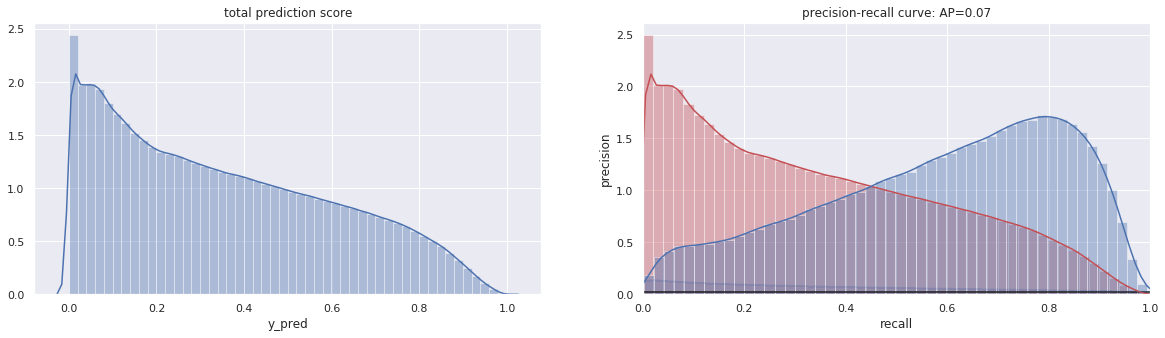

In [44]:
eval_result = evaluate(x_test[original_feature_cols], y_test.label.values, original_clf, clf_name='lgb')

### 2. feature 바꾼 모델

In [45]:
new_clf = lgb_model(x_trn[new_feature_cols], y_trn, 
                    x_val[new_feature_cols], y_val, 
                    feature_cols=new_feature_cols)

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.878191	valid_1's auc: 0.874885
[400]	training's auc: 0.894496	valid_1's auc: 0.890115
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.898611	valid_1's auc: 0.893445
elapsed time: 205.5207486152649


        acc    recall  precision  f1_score       auc
0  0.810322  0.562644   0.068085   0.12147  0.774537
         pred: 1   pred: 0
true: 1   245311    190686
true: 0  3357725  14913815


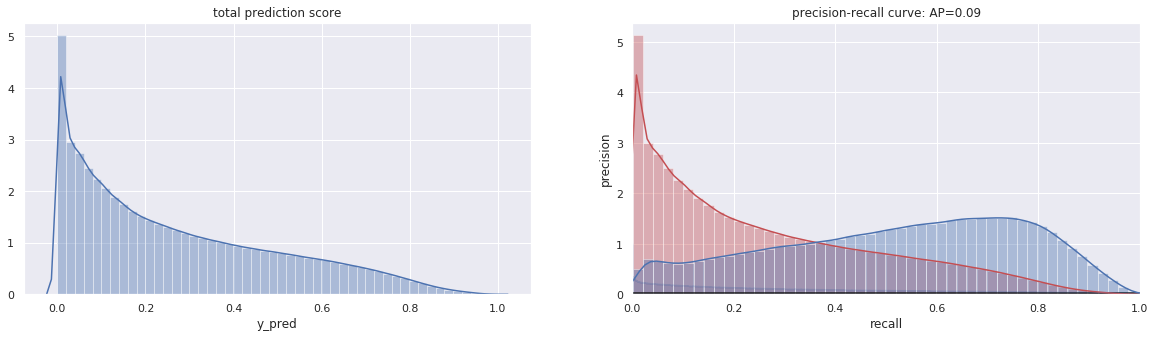

In [46]:
eval_result = evaluate(x_test[new_feature_cols], y_test.label.values, new_clf, clf_name='lgb')

***

## 5월?

In [50]:
# train
train_result = make_train_data(df_mart05)
x_trn = train_result['trn']['x']
y_trn = train_result['trn']['y']
x_val = train_result['val']['x']
y_val = train_result['val']['y']

make_train_data +++
label/sample:  0.2
sample/total:  0.11652977086187241
make_data_for_modeling---


### original

In [51]:
original_clf = lgb_model(x_trn[original_feature_cols], y_trn, 
                         x_val[original_feature_cols], y_val, 
                         feature_cols=original_feature_cols)

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.827338	valid_1's auc: 0.824723
[400]	training's auc: 0.838767	valid_1's auc: 0.833301
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.842321	valid_1's auc: 0.83517
elapsed time: 197.8106460571289


In [53]:
test_result = make_test_data(df_mart04)
x_test = test_result['x']
y_test = test_result['y']

        acc    recall  precision  f1_score       auc
0  0.731338  0.772058    0.07453  0.135937  0.837896
         pred: 1   pred: 0
true: 1   393632    116216
true: 0  4887921  13228407


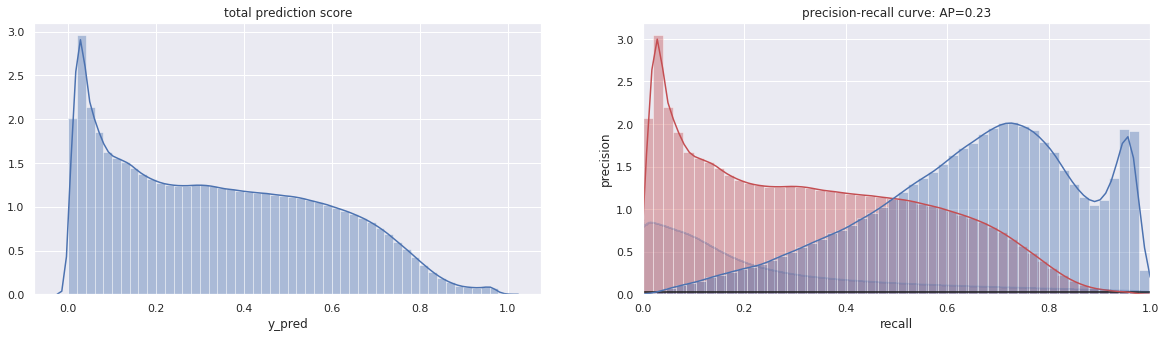

In [54]:
eval_result = evaluate(x_test[original_feature_cols], y_test.label.values, original_clf, clf_name='lgb')

In [92]:
pd.DataFrame({'feature': original_clf.feature_name(),
             'importance': original_clf.feature_importance()}).sort_values('importance', ascending=False).head(20)

feature  importance
44     avg_subscription_period        3402
6            last_equip_period        2895
7                  bas_fee_amt        2386
5              svc_scrb_period        2271
1                          age        1991
8              bas_ofr_data_gb        1326
9                  eqp_out_prc        1181
53            data_usage_ratio         916
49               real_avg_arpu         909
46             real_arpu_bf_m1         817
47             real_arpu_bf_m2         691
50           bf_m3_fee_chg_cnt         689
54  bf_m6_data_usage_ratio_avg         635
48             real_arpu_bf_m3         632
3              mng_nice_cb_scr         594
27      data_usage_in_gb_bf_m1         556
26      data_usage_in_gb_bf_m0         554
10               allot_prn_amt         526
78                     channel         514
11               pmth_inv_bamt         470

### new

In [55]:
new_clf = lgb_model(x_trn[new_feature_cols], y_trn, 
                    x_val[new_feature_cols], y_val, 
                    feature_cols=new_feature_cols)

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.818579	valid_1's auc: 0.815349
[400]	training's auc: 0.825333	valid_1's auc: 0.818486
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.827843	valid_1's auc: 0.81915
elapsed time: 170.5464370250702


In [56]:
eval_result = evaluate(x_test[new_feature_cols], y_test.label.values, new_clf, clf_name='lgb')

        acc    recall  precision  f1_score       auc
0  0.710477  0.759964   0.068484  0.125645  0.819553
         pred: 1   pred: 0
true: 1   387466    122382
true: 0  5270328  12846000


In [93]:
pd.DataFrame({'feature': new_clf.feature_name(),
             'importance': new_clf.feature_importance()}).sort_values('importance', ascending=False).head(20)

feature  importance
7                  bas_fee_amt        2627
1                          age        2369
6            last_equip_period        2290
8              bas_ofr_data_gb        1461
9                  eqp_out_prc        1425
5              svc_scrb_period        1209
52            data_usage_ratio        1173
48               real_avg_arpu        1099
45             real_arpu_bf_m1         943
53  bf_m6_data_usage_ratio_avg         873
47             real_arpu_bf_m3         808
3              mng_nice_cb_scr         802
46             real_arpu_bf_m2         783
26      data_usage_in_gb_bf_m0         735
49           bf_m3_fee_chg_cnt         718
27      data_usage_in_gb_bf_m1         671
10               allot_prn_amt         665
44            avg_chg_duration         617
11               pmth_inv_bamt         588
51  bf_m6_avg_data_usage_in_gb         557

***

## 2.특정 고객(voc) 살펴보기
1. 데이터 소진율이 적은데 upsell 확률이 높음
    - 7300818751, 7301516452
2. 심야데이터 사용 고객들 스코어가 너무 높음
    - 7278902818

### shap

In [58]:
import shap
original_explainer = shap.TreeExplainer(original_clf)
new_explainer = shap.TreeExplainer(new_clf)

In [59]:
target = '7300818751'
print('기존 score: ', original_clf.predict(df_input06[df_input06['svc_mgmt_num']==target][original_feature_cols])[0])
print('새 모델 score: ', new_clf.predict(df_input06[df_input06['svc_mgmt_num']==target][new_feature_cols])[0])

기존 score:  0.49738542872722924
새 모델 score:  0.14329856117387793


In [60]:
original_shap_values = original_explainer.shap_values(df_input06[df_input06['svc_mgmt_num']== target][original_feature_cols])
new_shap_values = new_explainer.shap_values(df_input06[df_input06['svc_mgmt_num']== target][new_feature_cols])

In [62]:
shap.force_plot(original_explainer.expected_value, original_shap_values[0,:],  df_input06[df_input06['svc_mgmt_num']==target][original_feature_cols])

In [63]:
shap.force_plot(new_explainer.expected_value, new_shap_values[0,:],  df_input06[df_input06['svc_mgmt_num']==target][new_feature_cols])

In [64]:
target = '7301516452'
print('기존 score: ', original_clf.predict(df_input06[df_input06['svc_mgmt_num']==target][original_feature_cols])[0])
print('새 모델 score: ', new_clf.predict(df_input06[df_input06['svc_mgmt_num']==target][new_feature_cols])[0])

기존 score:  0.7654483259569067
새 모델 score:  0.18463745363366055


In [65]:
original_shap_values = original_explainer.shap_values(df_input06[df_input06['svc_mgmt_num']== target][original_feature_cols])
new_shap_values = new_explainer.shap_values(df_input06[df_input06['svc_mgmt_num']== target][new_feature_cols])

In [66]:
shap.force_plot(original_explainer.expected_value, original_shap_values[0,:],  df_input06[df_input06['svc_mgmt_num']==target][original_feature_cols])

In [67]:
shap.force_plot(new_explainer.expected_value, new_shap_values[0,:],  df_input06[df_input06['svc_mgmt_num']==target][new_feature_cols])

In [68]:
target = '7278902818'
print('기존 score: ', original_clf.predict(df_input06[df_input06['svc_mgmt_num']==target][original_feature_cols])[0])
print('새 모델 score: ', new_clf.predict(df_input06[df_input06['svc_mgmt_num']==target][new_feature_cols])[0])

기존 score:  0.5707488959331114
새 모델 score:  0.3662507043014401


In [69]:
original_shap_values = original_explainer.shap_values(df_input06[df_input06['svc_mgmt_num']== target][original_feature_cols])
new_shap_values = new_explainer.shap_values(df_input06[df_input06['svc_mgmt_num']== target][new_feature_cols])

In [70]:
shap.force_plot(original_explainer.expected_value, original_shap_values[0,:],  df_input06[df_input06['svc_mgmt_num']==target][original_feature_cols])

In [71]:
shap.force_plot(new_explainer.expected_value, new_shap_values[0,:],  df_input06[df_input06['svc_mgmt_num']==target][new_feature_cols])

***

## 3.6월 prediction score distribution

In [72]:
df_input06['original_score'] = original_clf.predict(df_input06[original_feature_cols])
df_input06['new_score'] = new_clf.predict(df_input06[new_feature_cols])

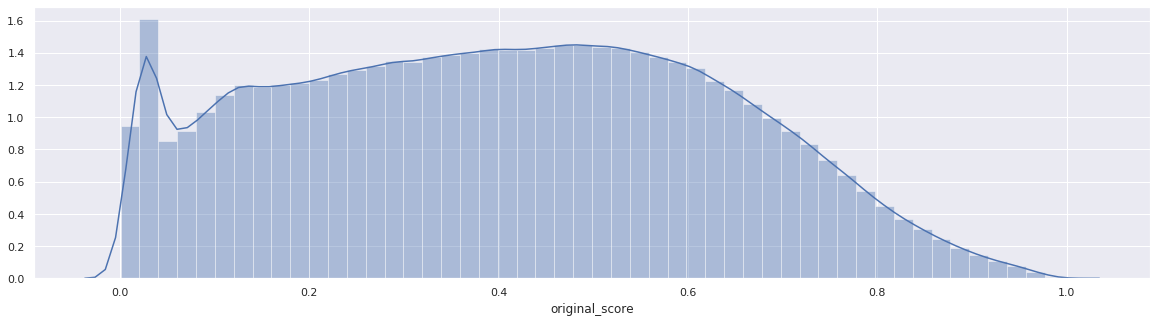

In [74]:
sns.set(rc={'figure.figsize': (20,5)})
sns.distplot(df_input06.sample(frac=0.1)['original_score'])

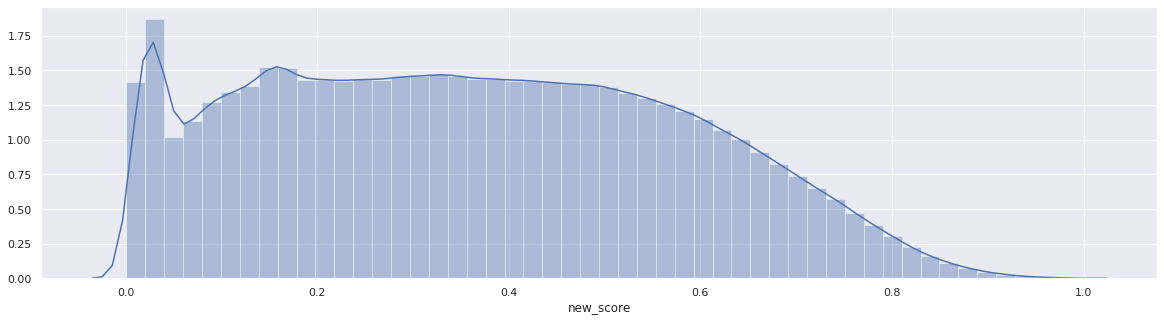

In [75]:
sns.set(rc={'figure.figsize': (20,5)})
sns.distplot(df_input06.sample(frac=0.1)['new_score'])

In [80]:
df_input06['original_rk'] = df_input06.original_score.rank(ascending=False)
df_input06['new_rk'] = df_input06.new_score.rank(ascending=False)

In [94]:
df_input06[['original_score', 'new_score', 'original_rk', 'new_rk']].sort_values('original_rk').head(20)

original_score  new_score  original_rk  new_rk
108233        0.999060   0.987882          1.0     8.0
16420         0.997928   0.983379          2.0    83.0
33078         0.997688   0.983021          3.0    92.0
54314         0.997658   0.979016          4.0   253.0
89601         0.997482   0.980078          5.0   201.0
16124         0.997472   0.975624          6.0   487.0
483486        0.997447   0.961649          7.0  1901.0
109804        0.997212   0.977239          8.0   368.0
108428        0.997003   0.979111          9.0   247.0
32949         0.996947   0.976525         10.0   425.0
164574        0.996862   0.979202         11.0   245.0
371258        0.996736   0.978734         12.0   271.0
127186        0.996717   0.977961         13.0   310.0
257725        0.996104   0.987701         14.0    10.0
202866        0.995708   0.981692         15.0   129.0
407865        0.995428   0.965472         16.0  1428.0
277461        0.995392   0.977538         17.0   343.0
13930         0.995376   0.970750         18.0   912.0
7649          0.995232   0.975749         19.0   478.0
277390        0.994978   0.987434         20.0    12.0

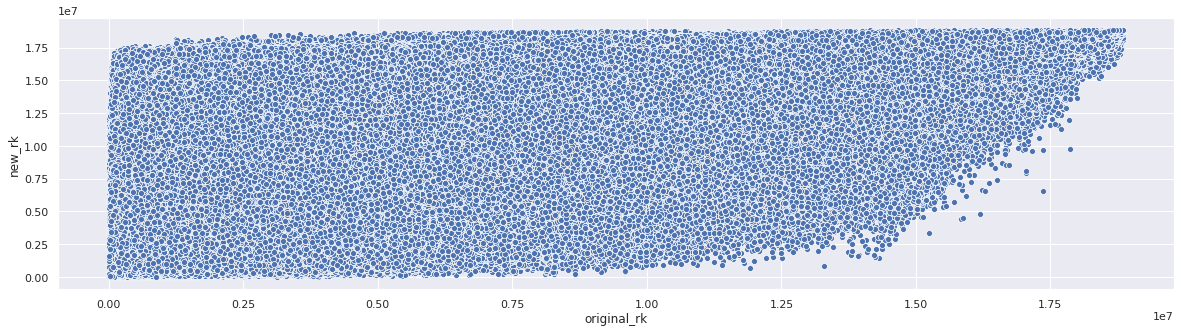

In [83]:
sns.scatterplot(df_input06['original_rk'], df_input06['new_rk'])

In [88]:
k_list = [1000000, 2000000, 3000000, 4000000, 5000000, 6000000]

for k in k_list:
    print('='*50)
    print('k: ', k)
    df_over_k = df_input06[df_input06['original_rk'] < k]
    print('retention_ratio: ', df_over_k[df_over_k['new_rk'] < k].shape[0] / df_over_k.shape[0])
    print('')

k:  1000000
retention_ratio:  0.544899544899545

k:  2000000
retention_ratio:  0.6451113225556613

k:  3000000
retention_ratio:  0.7053645684548562

k:  4000000
retention_ratio:  0.7478621869655467

k:  5000000
retention_ratio:  0.7786917557383511

k:  6000000
retention_ratio:  0.8028358004726334

